In [2]:
from graphstats import sbm
import graspy
import numpy as np
from graspy.embed import AdjacencySpectralEmbed as ASE
import itertools as it

from sklearn.neighbors import KernelDensity as KDE

import matplotlib.pyplot as plt
%matplotlib inline

The goal of this notebook is to propose a hypothesis test for testing whether or not two graphs with known vertex alginment share the same latent positions. This is a more restricted setting than the setting presented in Semi-par and so it should be possible to leverage the known vertex alignment to construct a more powerful test. 

Consider the following setting.
Let $ A^{(1)}, A^{(2)} $ be observed adjacency matrices on $ V $ where it is assumed $ A \sim RDPG(X_{1}) $ and $ B \sim RDPG(X_{2}) $. Let $ X_{1}, X_{2} \in \mathbb{R}^{n \times d} $ be stacked latent positions where the $ i^{th} $ row of $ X_{j} $ is the latent position of node $ i $ that generated $ A^{(j)} $. In this setting, a natural question to ask is whether or not $ X_{1}X_{1}^{T} = X_{2}X_{2}^{T} $. Note that $ X_{i}X_{i}^{T} \in \mathbb{R}^{n \times n} $.

Or testing 
\begin{align*}
H_{0}: X_{1}X_{1}^{T} &= X_{2}X_{2}^{T} \\
& vs \\
H_{1}: X_{1}X_{1}^{T} &\neq X_{2}X_{2}^{T}
\end{align*}

I propose a simple procedure in the vertex aligned setting. Let $ S \subset V $ and let $ A^{(i)}_{S, j} $ denote the adjacency matrix in which the adjacencies of vertices in S in graph i are replaced by the adjacencies of vertices in S in graph j. In matrix syntax, let $ a_{k,\ell}^{i} $ denote the (j, $\ell$)th entry of graph i. Then the k,$\ell$th entry of $ A^{(i)}_{S,j} $ is $ a_{k,\ell}^{i} $ if $ k $ or $ \ell $ is in $ S $ and $ a_{k, \ell}^{j} $ otherwise.

The testing procedure will go as follows. Fix $ K \le \frac{|V|}{2}\in \mathbb{N} $. Let $ \hat{X}_{i} = ASE(A^{(i)}) $ and let $ \hat{P}_{i} = \hat{X}_{i} \hat{X}_{i}^{T} $. Let $ B^{1}, B^{2} \sim RDPG(\hat{P}_{i}) $ on $ V $. Let S be a random subset of V of size K. Now let $ B^{1}_{S, 2} $ be defined as above and consider $ \hat{Y}_{1} = ASE(B^{1}) $ and $ \hat{Y}_{2} = ASE(B^{1}_{S, 2}) $ and let $ T = ||\hat{Y}_{1}\hat{Y}_{1}^{T} - \hat{Y}_{2}\hat{Y}_{2}^{T}||_{F}$. Repeating this a bunch of times we can get two distributions of $ T $ under the null. We reject if the observed statistic is in the $ (1 - \alpha)^{th} $ quantile in both estimated distributions.

NB: It is unclear whether or not the RDPG assumption is necessary to utilize a similar method to the one described. We could use any distribution on a single graph and just consider the frobenius norm of the adj matricies after switcheroos. Moreover, perhaps a better statistic will be $ T_{1} + T_{2} $ where we get $ T_{1} $ from putting columns of B into A and $ T_{2} $ from putting columns of A into B.

This notebook will

-- implement this testing procedure

-- empirically show its validity

-- empirically show its consistency

-- compare power to semi-par

-- hopefully evolve into something sensible :-)

In [25]:
## Implementation
from tqdm import tqdm_notebook as tqdm

def choose(n, k):
    return np.math.factorial(n) / (np.math.factorial(k) * np.math.factorial(n-k))

def switcheroo(A, B, idx):
    new_A = A.copy()
    new_B = B.copy()
#     for idx in S:
    new_A[idx,:]=B[idx,:]
    new_A[:, idx]=B[:,idx]

    new_B[idx,:]=A[idx,:]
    new_B[:,idx]=A[:,idx]
    
    return new_A, new_B

def generate_null_distribution(P, n=100, k=5, b=100, seed=None, verbose=False):
    """
    P - probability matrix
    n - number of nodes
    k - the size of the random subset to switch
    b - number of iterations
    """
    if seed is None:
        seed = np.random.randint(10**6)
    np.random.seed(seed)
    
    if k is None:
        k = 5
        
    
    #print(len(list(combinations)))
    
    statistics = []
    
    if verbose:
        for i in tqdm(range(b)):
            combinations = it.combinations(range(n), k)
            T = 0
            for combo in combinations:
                if P.shape[0] != n:
                    S = np.random.binomial(n, 0.5)
                    A1 = sbm.adj_matrix(n, [S/n, 1 - S/n], P)
                    A2 = sbm.adj_matrix(n, [S/n, 1 - S/n], P)
                else:
                    A1 = sbm.adj_matrix(n, np.ones(n)/n, P)
                    A2 = sbm.adj_matrix(n, np.ones(n)/n, P)

                newA1, newA2 = switcheroo(A1, A2, combo)

                ase_object11 = ASE()
                X_hat11 = ase_object11.fit_transform(A1)

                ase_object12 = ASE()
                X_hat12 = ase_object12.fit_transform(newA1)
                
                P11 = X_hat11 @ X_hat11.T
                P12 = X_hat12 @ X_hat12.T
                
                T1 = np.linalg.norm(P11 - P12)
                
                ase_object21 = ASE()
                X_hat21 = ase_object21.fit_transform(A2)

                ase_object22 = ASE()
                X_hat22 = ase_object22.fit_transform(newA2)
                
                P21 = X_hat21 @ X_hat21.T
                P22 = X_hat22 @ X_hat22.T

                T2=np.linalg.norm(P21 - P22)
                T += T1 + T2
            statistics.append(T)
    else:
        for i in range(b):
            tempA1 = sbm.adj_matrix(n, np.ones(n)/n, P)
            tempA2 = sbm.adj_matrix(n, np.ones(n)/n, P)

            temp_newA1 = switcheroo(tempA1, tempA2, k)

            ase_object1 = ASE()
            X_hat1 = ase_object1.fit_transform(tempA1)
            ase_object2 = ASE()
            X_hat2 = ase_object2.fit_transform(temp_newA1)

            # matmul takes a while..
            P1 = X_hat1 @ X_hat1.T
            P2 = X_hat2 @ X_hat2.T

            T=np.linalg.norm(P1 - P2)
            statistics.append(T)
        
    return np.array(statistics)

def find_p(statistics, T):
    return np.sum(statistics>T)/len(statistics)

def power_simulations(alpha, n, pi0, k, b, epsilons, MC, seed=None):
    if seed is None:
        seed=np.random.randint(10**6)
    np.random.seed(seed)
    
    B1 = np.array([
    [0.6, 0.4],
    [0.4, 0.5]
    ])
    
    rejections=np.zeros(len(epsilons))
    
    for i, eps in enumerate(epsilons):
        for j in range(MC):
            S = np.random.binomial(n, pi0)
            pi = [S/n, 1 - S/n]
            B2 = B1 + np.diag(eps*np.ones)

            A1 = sbm.adj_matrix(n, pi, B1)
            A2 = sbm.adj_matrix(n, pi, B2)

            new_A1 = switcheroo(A1, A2, k)

            ase_object1 = ASE()
            X_hat1 = ase_object1.fit_transform(A1)
            ase_object2 = ASE()
            X_hat2 = ase_object2.fit_transform(new_A1)

            P1 = X_hat1 @ X_hat1.T
            P2 = X_hat2 @ X_hat2.T
            
            T = np.linalg.norm(P1 - P2)
            
            stats1 = generate_null_distribution(P1, n, k, b)
            p1 = find_p(stats1, T)
            
            stats2 = generate_null_distribution(P2, n, k, b)
            p2 = find_p(stats2, T)
            
            p=max(p1, p2)
            if p < alpha:
                rejections[i]+=1    
                
    return rejections/MC

In [4]:
#statistics = generate_null_distribution(B1, 30, k = 1, b=300, verbose=True)
import _pickle as pickle
# pickle.dump(statistics, open('statistics.pkl', 'wb'))
statistics = pickle.load(open('statistics.pkl', 'rb'))

In [6]:
#statistics1 = generate_null_distribution(P1, 30, k =1, b=300, verbose=True)
import _pickle as pickle
# pickle.dump(statistics1, open('statistics1.pkl', 'wb'))
statistics1 = pickle.load(open('statistics1.pkl', 'rb'))

In [5]:
#statistics2 = generate_null_distribution(P2, 30, k =1, b=300, verbose=True)
import _pickle as pickle
# pickle.dump(statistics2, open('statistics2.pkl', 'wb'))
statistics2 = pickle.load(open('statistics2.pkl', 'rb'))

(0.9944171905517578, 0.3419501483440399)

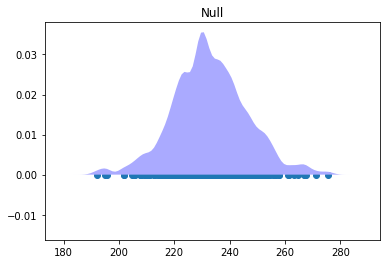

In [7]:
from scipy.stats import norm
fig, ax = plt.subplots(1,1)
# xs = np.arange(min(statistics) - np.std(statistics, ddof=1), max(statistics) + np.std(statistics, ddof=1))
# ax.scatter(statistics, np.zeros(len(statistics)))
kde0 = KDE(bandwidth=2)
kde0.fit(statistics.reshape(-1, 1), )
log_dens = kde.score_samples(xs.reshape(-1,1))
ax.fill(xs, np.exp(log_dens), fc='#AAAAFF')
ax.set_title('Null')
from scipy.stats import shapiro
p = shapiro(statistics)
p # fail to reject that T is normally distributed

(0.9979431629180908, 0.9736108183860779)

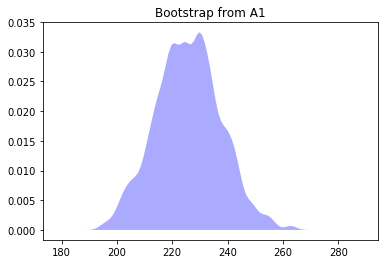

In [8]:
fig, ax = plt.subplots(1,1)
# xs = np.arange(min(statistics1) - np.std(statistics1, ddof=1), max(statistics1) + np.std(statistics1, ddof=1))
# ax.scatter(statistics1, np.zeros(len(statistics1)))
kde1 = KDE(bandwidth=2)
kde1.fit(statistics1.reshape(-1, 1), )
log_dens = kde1.score_samples(xs.reshape(-1,1))
ax.fill(xs, np.exp(log_dens), fc='#AAAAFF')
ax.set_title('Bootstrap from A1')
from scipy.stats import shapiro
p = shapiro(statistics1)
p # fail to reject that T is normally distributed

(0.9962352514266968, 0.6976736187934875)

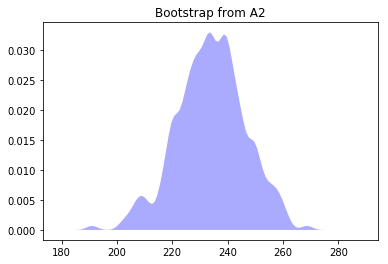

In [9]:
fig, ax = plt.subplots(1,1)
#xs = np.arange(min(statistics2) - np.std(statistics2, ddof=1), max(statistics2) + np.std(statistics2, ddof=1))
#ax.scatter(statistics2, np.zeros(len(statistics2)))
kde2 = KDE(bandwidth=2)
kde2.fit(statistics2.reshape(-1, 1), )
log_dens = kde2.score_samples(xs.reshape(-1,1))
ax.fill(xs, np.exp(log_dens), fc='#AAAAFF')
ax.set_title('Bootstrap from A2')
from scipy.stats import shapiro
p = shapiro(statistics2)
p # fail to reject that T is normally distributed

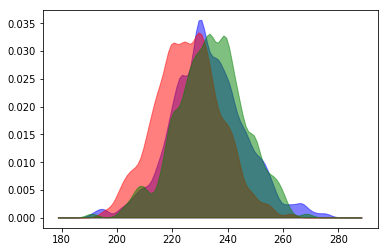

In [16]:
fig, ax = plt.subplots(1,1)
#xs = np.arange(min(statistics2) - np.std(statistics2, ddof=1), max(statistics2) + np.std(statistics2, ddof=1))
#ax.scatter(statistics2, np.zeros(len(statistics2)))

kde0 = KDE(bandwidth=2)
kde0.fit(statistics.reshape(-1, 1), )
log_dens = kde.score_samples(xs.reshape(-1,1))
ax.fill(xs, np.exp(log_dens), c='b', alpha=0.5)
# ax.set_title('Null')
kde1 = KDE(bandwidth=2)
kde1.fit(statistics1.reshape(-1, 1), )
log_dens = kde1.score_samples(xs.reshape(-1,1))
ax.fill(xs, np.exp(log_dens), c='r', alpha=0.5)
# ax.set_title('Bootstrap from A1')
kde2 = KDE(bandwidth=2)
kde2.fit(statistics2.reshape(-1, 1), )
log_dens = kde2.score_samples(xs.reshape(-1,1))
ax.fill(xs, np.exp(log_dens), c='g', alpha=0.5)
# ax.set_title('Bootstrap from A2')

In [43]:
from scipy.stats import ks_2samp as KS
W01, p01 = KS(statistics, statistics1)
W02, p02 = KS(statistics, statistics2)
W12, p12= KS(statistics1, statistics2)
print(p01, p02, p12)

7.061866088503691e-08 0.2001071676421562 7.129752615737157e-12


In [ ]:
# Is the fact that we reject for 01, 12 attributable to the fact that "the likelihood surface is flat"

In [49]:
# Compare to -- N(0, 1), n = 10 testing equality of means
Ts = []
for i in range(300):
    X = np.random.normal(0, 1, 10)
    X_bar = np.mean(X)

    Y = np.random.normal(0,1,10)
    Y_bar=np.mean(Y)
    
    T = X_bar - Y_bar
    Ts.append(T)
Ts = np.array(Ts)

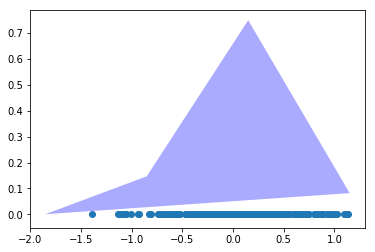

In [61]:
fig, ax = plt.subplots(1,1)
xs = np.arange(min(Ts) - np.std(Ts, ddof=1), max(Ts) + np.std(Ts, ddof=1))
ax.scatter(Ts, np.zeros(len(Ts)))
kde = KDE(bandwidth=0.2, kernel='gaussian')
kde.fit(Ts.reshape(-1, 1), )
log_dens = kde.score_samples(xs.reshape(-1,1))
ax.fill(xs, np.exp(log_dens), fc='#AAAAFF')

In [66]:
X = np.random.normal(0, 1, 10)
Y = np.random.normal(0,1,10)
T_bs =[]
for b in range(300):
    samplex = np.random.choice(X, 10, replace=True)
    sampley = np.random.choice(Y, 10, replace=True)

    X_bar = np.mean(samplex)
    Y_bar =np.mean(sampley)
    
    T = X_bar - Y_bar
    T_bs.append(T)
T_bs=np.array(T_bs)

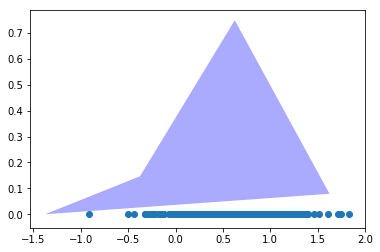

In [67]:
fig, ax = plt.subplots(1,1)
xs = np.arange(min(T_bs) - np.std(T_bs, ddof=1), max(T_bs) + np.std(T_bs, ddof=1))
ax.scatter(T_bs, np.zeros(len(Ts)))
kde = KDE(bandwidth=0.2, kernel='gaussian')
kde.fit(T_bs.reshape(-1, 1), )
log_dens = kde.score_samples(xs.reshape(-1,1))
ax.fill(xs, np.exp(log_dens), fc='#AAAAFF')

In [68]:
from scipy.stats import ks_2samp
W, p = ks_2samp(Ts, T_bs)
p

5.7105037378956984e-27

In [19]:
# Set up
np.random.seed(1)
alpha=0.05
n = 100
pi0=0.5
pi=[pi0, 1-pi0]
k=1
b=100
epsilons=[0, 0.05, 0.1, 0.2]
MC=200

B1 = np.array([
    [0.6, 0.3],
    [0.3, 0.6]
])

B2 = B1.copy() #+ np.diag(epsilons*np.ones)

A1 = sbm.adj_matrix(n, pi, B1)
A2 = sbm.adj_matrix(n, pi, B2)

new_A1, new_A2 = switcheroo(A1, A2, k)

ase_object1 = ASE()
X_hat1 = ase_object1.fit_transform(A1)
ase_object2 = ASE()
X_hat2 = ase_object2.fit_transform(new_A1)

P1 = X_hat1 @ X_hat1.T
P2 = X_hat2 @ X_hat2.T

T = np.linalg.norm(P1 - P2)
T

1.5370897696001196

In [24]:
P2

array([[0.56745137, 0.6022672 , 0.58451126, ..., 0.24163599, 0.30632868,
        0.30364064],
       [0.6022672 , 0.64836532, 0.62804146, ..., 0.31690206, 0.39253268,
        0.38406787],
       [0.58451126, 0.62804146, 0.6085122 , ..., 0.29957065, 0.37205046,
        0.36457694],
       ...,
       [0.24163599, 0.31690206, 0.29957065, ..., 0.50230344, 0.57590256,
        0.53767329],
       [0.30632868, 0.39253268, 0.37205046, ..., 0.57590256, 0.66218665,
        0.61937513],
       [0.30364064, 0.38406787, 0.36457694, ..., 0.53767329, 0.61937513,
        0.5800196 ]])

In [45]:
stats1 = generate_null_distribution(P1, n, b=150, verbose=True)

In [47]:
find_p(stats1, T)

0.12

In [46]:
stats1

array([12.32545785, 12.04355023, 10.50550961, 11.09417691, 11.05248546,
       10.74473827, 11.98479088, 10.68801406, 11.97084167, 12.22152218,
       11.89973904, 10.88112489, 12.57005568, 12.13090312, 11.91952248,
       10.50943314, 11.58639974, 10.58566944, 11.37762376, 11.98701588,
       10.83606917, 11.95654899, 11.24001557, 11.58307547, 11.61248323,
       11.89237353, 11.19376096, 11.65263925, 12.41030794, 12.90749636,
       11.53820285, 11.91276755, 11.29774965, 11.7119777 , 12.96390587,
       11.46324484, 11.41815651,  9.82381174, 11.89374027, 12.48720084,
       12.50566041, 10.70961065, 12.04279125, 11.31452739, 11.75758982,
       11.48027861, 11.69439867, 12.33551773, 10.85927868, 11.90205876,
       11.14819   , 11.32702162, 11.10585972, 10.86887622, 12.83327069,
       12.6724352 , 11.02919819, 10.96893065, 11.55758993, 11.16240659,
       10.80417826, 11.68411754, 10.9248334 , 11.54952929, 10.35003646,
       12.60932958, 10.67444866, 10.89436539, 11.86525964, 11.40

One question to answer is how well the estimated distribution of $ T $ approximates the distribution of $ T $ under the null. As carey pointed out, it is unclear how graph bootstrapping will affect the validity of this procedure. Hence, the next few cells will aid us in understanding the answer (and even the question).

First, we fix $ K \in [|V|] \le? \frac{|V|}{2} $. Then we will generate the distribution of the test statistic? under the "true" null. This requires drawing M pairs of graphs from the true latent positions, considering the $ 2{n \choose K} $ transplanted graphs for each pair and averaging the distance of the frobenius norms of the difference between the transplanted graph and the original graph. We do this for both graphs and end up with

$$ T = \frac{1}{2 n choose K} \sum_{s \in S} || A^{b, 1} - A^{b, 1}_{s, 2} ||_{F} + \frac{1}{2 n choose K} \sum_{s \in S} || A^{b, 2} - A^{b, 2}_{s, 1} ||_{F} $$

We do this M times to generate a distribution under the null.

In [17]:
for i in it.combinations(range(3), 2):
    print(A1[i, :])

[[0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
  1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
  0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.
  1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
[[0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
  1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
  0. 1. 0. 0.]
 [1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0

In [ ]:
## Validity

In [ ]:
## Consistency

In [ ]:
## vs semi-par